In [ ]:
%load_ext autoreload
%autoreload 2

In [78]:



import glob
import itertools
import math
import os

import igraph as ig
import leidenalg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import khtools


ksize = 21
moltype = 'DNA'

ignore_abundance = False
downsample = False


# Defaults from 'sourmash index'

bf_size = 1e5
n_children = 2
scaled = False

n_neighbors = 3

try:
    import scanpy.api as sc
except FutureWarning:
    import scanpy as sc

sc.logging.print_versions()


from sourmash import signature as sig
from sourmash.compare import compare_all_pairs
from sourmash.sbt import Leaf
from sourmash.sbtmh import SigLeaf, create_sbt_index
from sourmash import sourmash_args
from sourmash.logging import notify

import umap

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
annotations = pd.read_csv('https://github.com/czbiohub/tabula-muris/raw/master/00_data_ingest/18_global_annotation_csv/annotations_facs.csv', 
                          index_col='cell')
annotations.index = annotations.index.str.replace('.', '-')
annotations.columns = annotations.columns.str.replace('.', '_')
annotations['sample_id'] = annotations.index
annotations = annotations.fillna("NA")
print(annotations.shape)
annotations.head()

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(44949, 24)


,Neurog3>0_raw,Neurog3>0_scaled,cell_ontology_class,cell_ontology_id,cluster_ids,free_annotation,mouse_id,mouse_sex,plate_barcode,subsetA,...,subsetC_cluster_ids,subsetD,subsetD_cluster_ids,subsetE,subsetE_cluster_ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2,sample_id
cell,,,,,,,,,,,,,,,,,,,,,
A1-B000610-3_56_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-7.182841,-10.895094,A1-B000610-3_56_F-1-1
A1-B002764-3_38_F-1-1,NA,NA,bladder urothelial cell,CL:1001428,3,Luminal bladder epithelial cell,3_38_F,F,B002764,NA,...,NA,NA,NA,NA,NA,NA,Bladder,4.199059,-11.050240,A1-B002764-3_38_F-1-1
A1-B002771-3_39_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_39_F,F,B002771,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-11.995435,-7.325534,A1-B002771-3_39_F-1-1
A1-D041914-3_8_M-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_8_M,M,D041914,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-6.820022,-14.174246,A1-D041914-3_8_M-1-1
A1-D042253-3_9_M-1-1,NA,NA,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_9_M,M,D042253,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-24.163538,-7.499349,A1-D042253-3_9_M-1-1


In [4]:
bladder_annotations = annotations.query('tissue == "Bladder"')
print(bladder_annotations.shape)
bladder_annotations.head()

(1378, 24)


,Neurog3>0_raw,Neurog3>0_scaled,cell_ontology_class,cell_ontology_id,cluster_ids,free_annotation,mouse_id,mouse_sex,plate_barcode,subsetA,...,subsetC_cluster_ids,subsetD,subsetD_cluster_ids,subsetE,subsetE_cluster_ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2,sample_id
cell,,,,,,,,,,,,,,,,,,,,,
A1-B000610-3_56_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-7.182841,-10.895094,A1-B000610-3_56_F-1-1
A1-B002764-3_38_F-1-1,NA,NA,bladder urothelial cell,CL:1001428,3,Luminal bladder epithelial cell,3_38_F,F,B002764,NA,...,NA,NA,NA,NA,NA,NA,Bladder,4.199059,-11.050240,A1-B002764-3_38_F-1-1
A1-B002771-3_39_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_39_F,F,B002771,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-11.995435,-7.325534,A1-B002771-3_39_F-1-1
A1-D041914-3_8_M-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_8_M,M,D041914,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-6.820022,-14.174246,A1-D041914-3_8_M-1-1
A1-D042253-3_9_M-1-1,NA,NA,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_9_M,M,D042253,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-24.163538,-7.499349,A1-D042253-3_9_M-1-1


In [5]:

folder = '/home/olga/pureScratch/olgabot-maca/facs/sourmash/'


all_signatures = glob.glob(f'{folder}/*.sig')
basenames = [os.path.basename(x) for x in all_signatures]
basenames[:10]

['A1-B000127-3_38_F-1-1_S1.sig',
 'A1-B000126-3_39_F-1-1_S289.sig',
 'A1-B000167-3_56_F-1-1_S228.sig',
 'A1-B000168-3_57_F-1-1_S177.sig',
 'A1-B000412-3_56_F-1-1_S110.sig',
 'A1-B000610-3_56_F-1-1_S28.sig',
 'A1-B000633-3_56_F-1-1_S266.sig',
 'A1-B000634-3_56_F-1-1_S253.sig',
 'A1-B000636-3_56_F-1-1_S126.sig',
 'A1-B000826-3_39_F-1-1_S167.sig']

In [6]:
%%time

bladder_files = list(itertools.chain(*[[x for x in basenames if x.startswith(cell_id)] for cell_id in bladder_annotations.index]))
len(bladder_files)


CPU times: user 9.16 s, sys: 4 ms, total: 9.16 s
Wall time: 9.19 s


In [7]:
bladder_files[:10]

['A1-B000610-3_56_F-1-1_S28.sig',
 'A1-B002764-3_38_F-1-1_S291.sig',
 'A1-B002771-3_39_F-1-1_S242.sig',
 'A1-D041914-3_8_M-1-1_S269.sig',
 'A1-D042253-3_9_M-1-1_S43.sig',
 'A1-MAA000487-3_10_M-1-1_S264.sig',
 'A10-B000610-3_56_F-1-1_S38.sig',
 'A10-B002764-3_38_F-1-1_S22.sig',
 'A10-B002771-3_39_F-1-1_S249.sig',
 'A10-D041914-3_8_M-1-1_S279.sig']

In [8]:
bladder_full_path = [folder + x for x in bladder_files]
print(len(bladder_full_path))
bladder_full_path[:10]

1270


['/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-B000610-3_56_F-1-1_S28.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-B002764-3_38_F-1-1_S291.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-B002771-3_39_F-1-1_S242.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-D041914-3_8_M-1-1_S269.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-D042253-3_9_M-1-1_S43.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-MAA000487-3_10_M-1-1_S264.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-B000610-3_56_F-1-1_S38.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-B002764-3_38_F-1-1_S22.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-B002771-3_39_F-1-1_S249.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-D041914-3_8_M-1-1_S279.sig']

In [9]:
ksize = 21
moltype = "DNA"
ignore_abundance = True

%%time

bladder_signatures = []
for filename in bladder_full_path:
     bladder_signatures.extend(sig.load_signatures(filename, ksize=ksize, select_moltype="DNA"))
print(len(bladder_signatures))
bladder_signatures[:5]

In [11]:
cells = [x.name().split("_S")[0] for x in bladder_signatures]
print(len(cells))
cells[:10]

1270


['A1-B000610-3_56_F-1-1',
 'A1-B002764-3_38_F-1-1',
 'A1-B002771-3_39_F-1-1',
 'A1-D041914-3_8_M-1-1',
 'A1-D042253-3_9_M-1-1',
 'A1-MAA000487-3_10_M-1-1',
 'A10-B000610-3_56_F-1-1',
 'A10-B002764-3_38_F-1-1',
 'A10-B002771-3_39_F-1-1',
 'A10-D041914-3_8_M-1-1']

In [12]:
%%time

bladder_similarities_ignore_abundanceTrue = compare_all_pairs(bladder_signatures, ignore_abundance=True, n_jobs=32)

Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 1269 done in 0.00000 secondstting similarities matrix for index 73 done in 0.00070 secondsSetting similarities matrix for index 160 done in 0.00059 seconds


CPU times: user 6.85 s, sys: 2.14 s, total: 8.99 s
Wall time: 9.64 s


Time taken to compare all pairs parallely is 9.63143 seconds 


In [13]:
bladder_similarities_ignore_abundanceTrue

memmap([[1.   , 0.018, 0.072, ..., 0.088, 0.088, 0.06 ],
        [0.018, 1.   , 0.012, ..., 0.014, 0.014, 0.006],
        [0.072, 0.012, 1.   , ..., 0.1  , 0.124, 0.076],
        ...,
        [0.088, 0.014, 0.1  , ..., 1.   , 0.1  , 0.146],
        [0.088, 0.014, 0.124, ..., 0.1  , 1.   , 0.106],
        [0.06 , 0.006, 0.076, ..., 0.146, 0.106, 1.   ]])

In [96]:
bladder_similarities_ignore_abundanceTrue_df = pd.DataFrame(bladder_similarities_ignore_abundanceTrue, index=cells, columns=cells)
bladder_similarities_ignore_abundanceTrue_df.head()

,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,A1-B002771-3_39_F-1-1,A1-D041914-3_8_M-1-1,A1-D042253-3_9_M-1-1,A1-MAA000487-3_10_M-1-1,A10-B000610-3_56_F-1-1,A10-B002764-3_38_F-1-1,A10-B002771-3_39_F-1-1,A10-D041914-3_8_M-1-1,...,P7-D042253-3_9_M-1-1,P7-MAA000487-3_10_M-1-1,P8-B000610-3_56_F-1-1,P8-B002764-3_38_F-1-1,P8-D042253-3_9_M-1-1,P8-MAA000487-3_10_M-1-1,P9-B000610-3_56_F-1-1,P9-B002771-3_39_F-1-1,P9-D042253-3_9_M-1-1,P9-MAA000487-3_10_M-1-1
A1-B000610-3_56_F-1-1,1.000,0.018,0.072,0.098,0.090,0.102,0.086,0.058,0.088,0.096,...,0.096,0.076,0.084,0.052,0.104,0.056,0.090,0.088,0.088,0.060
A1-B002764-3_38_F-1-1,0.018,1.000,0.012,0.028,0.014,0.020,0.008,0.008,0.014,0.018,...,0.006,0.012,0.012,0.010,0.008,0.014,0.016,0.014,0.014,0.006
A1-B002771-3_39_F-1-1,0.072,0.012,1.000,0.094,0.110,0.106,0.082,0.060,0.086,0.126,...,0.108,0.100,0.074,0.054,0.118,0.064,0.076,0.100,0.124,0.076
A1-D041914-3_8_M-1-1,0.098,0.028,0.094,1.000,0.078,0.100,0.078,0.056,0.084,0.100,...,0.086,0.080,0.080,0.056,0.098,0.062,0.088,0.074,0.104,0.064
A1-D042253-3_9_M-1-1,0.090,0.014,0.110,0.078,1.000,0.114,0.086,0.056,0.088,0.106,...,0.110,0.096,0.076,0.076,0.126,0.082,0.104,0.092,0.120,0.102


In [14]:
similarities = pd.DataFrame(bladder_similarities_ignore_abundanceTrue, index=cells, columns=cells)
print(similarities.shape)
similarities.head()

(1270, 1270)


,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,A1-B002771-3_39_F-1-1,A1-D041914-3_8_M-1-1,A1-D042253-3_9_M-1-1,A1-MAA000487-3_10_M-1-1,A10-B000610-3_56_F-1-1,A10-B002764-3_38_F-1-1,A10-B002771-3_39_F-1-1,A10-D041914-3_8_M-1-1,...,P7-D042253-3_9_M-1-1,P7-MAA000487-3_10_M-1-1,P8-B000610-3_56_F-1-1,P8-B002764-3_38_F-1-1,P8-D042253-3_9_M-1-1,P8-MAA000487-3_10_M-1-1,P9-B000610-3_56_F-1-1,P9-B002771-3_39_F-1-1,P9-D042253-3_9_M-1-1,P9-MAA000487-3_10_M-1-1
A1-B000610-3_56_F-1-1,1.000,0.018,0.072,0.098,0.090,0.102,0.086,0.058,0.088,0.096,...,0.096,0.076,0.084,0.052,0.104,0.056,0.090,0.088,0.088,0.060
A1-B002764-3_38_F-1-1,0.018,1.000,0.012,0.028,0.014,0.020,0.008,0.008,0.014,0.018,...,0.006,0.012,0.012,0.010,0.008,0.014,0.016,0.014,0.014,0.006
A1-B002771-3_39_F-1-1,0.072,0.012,1.000,0.094,0.110,0.106,0.082,0.060,0.086,0.126,...,0.108,0.100,0.074,0.054,0.118,0.064,0.076,0.100,0.124,0.076
A1-D041914-3_8_M-1-1,0.098,0.028,0.094,1.000,0.078,0.100,0.078,0.056,0.084,0.100,...,0.086,0.080,0.080,0.056,0.098,0.062,0.088,0.074,0.104,0.064
A1-D042253-3_9_M-1-1,0.090,0.014,0.110,0.078,1.000,0.114,0.086,0.056,0.088,0.106,...,0.110,0.096,0.076,0.076,0.126,0.082,0.104,0.092,0.120,0.102


,cell1,cell2,similarity_without_abundance
0,A1-B000610-3_56_F-1-1,A1-B000610-3_56_F-1-1,1.000
1,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,0.018
2,A1-B000610-3_56_F-1-1,A1-B002771-3_39_F-1-1,0.072
3,A1-B000610-3_56_F-1-1,A1-D041914-3_8_M-1-1,0.098
4,A1-B000610-3_56_F-1-1,A1-D042253-3_9_M-1-1,0.090


In [15]:
! ls -lha /home/olga/pureScratch/olgabot-maca/facs/

total 122G
drwxrwxr-x 1 olga olga    0 Aug 16 15:00 .
drwxrwxr-x 1 olga olga    0 Aug  1 01:58 ..
-rw-rw-r-- 1 olga olga 9.0M Aug 16 15:00 bladder_compare_k21_ignoreabundanceTrue.csv
drwxrwxr-x 1 olga olga    0 Aug 12 06:29 .sbt.tabula-muris-k21
drwxrwxr-x 1 olga olga    0 Aug  1 16:45 sourmash
-rw-rw-r-- 1 olga olga  47G Aug  6 19:18 sourmash_compare_k21.csv
-rw-rw-r-- 1 olga olga  14G Aug  7 11:51 sourmash_compare_k21_ignore_abundance.csv
-rw-rw-r-- 1 olga olga  48G Aug  6 19:21 sourmash_compare_k31.csv
-rw-rw-r-- 1 olga olga 2.5K Aug  9 14:30 sourmash_compare_k31.hdf5
-rw-rw-r-- 1 olga olga  14G Aug  7 11:51 sourmash_compare_k31_ignore_abundance.csv
drwxrwxr-x 1 olga olga    0 Aug 15 10:26 sourmash_compute_all
drwxrwxr-x 1 olga olga    0 Aug 16 16:30 sourmash_tissues
-rw-rw-r-- 1 olga olga  13M Aug 12 06:50 tabula-muris-k21.sbt.json


In [16]:
similarities.to_csv("/home/olga/pureScratch/olgabot-maca/facs/bladder_compare_k21_ignoreabundanceTrue.csv")

In [17]:
bladder_annotations = annotations.loc[similarities.index]

In [24]:
color_cols = [#'tissue', 'subtissue', 
              'cell_ontology_class', 'mouse_id', 'mouse_sex', 'plate_barcode', 'free_annotation']
palette_names = [#'tab20', 'tab10',
                 'Set2', 'husl', 'Paired', 'Set2', 'Set1']
palettes = dict(zip(color_cols, palette_names))
palettes

{'cell_ontology_class': 'Set2',
 'mouse_id': 'husl',
 'mouse_sex': 'Paired',
 'plate_barcode': 'Set2',
 'free_annotation': 'Set1'}

NameError: name 'graphs' is not defined

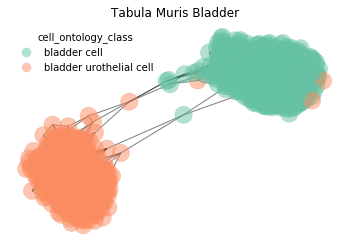

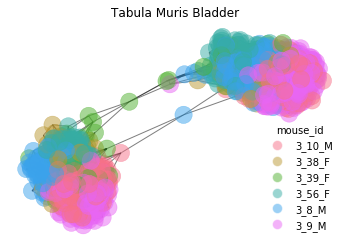

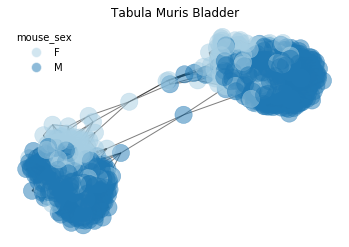

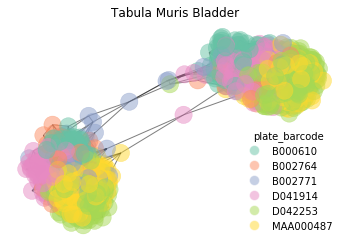

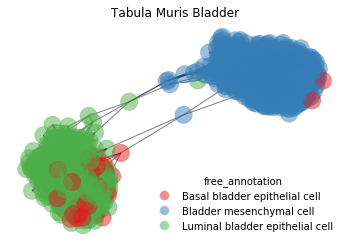

In [88]:
%%time


n_neighbors = 5
figure_folder = 's3://kmer-hashing/tabula-muris/n_hashes=500/bladder/'
figure_prefix = f'molecule={moltype}_ksize={ksize}_ignore-abundance={ignore_abundance}'
title = 'Tabula Muris Bladder'

key = f'k{ksize}_without_abundance_neighbors{n_neighbors}'


g, pos = khtools.knn.build_graph_and_plot(similarities, bladder_annotations, n_neighbors,
                                          color_cols, palettes, figure_folder, figure_prefix, title)

graphs[key] = g
positions[key] = pos

In [ ]:
graphs = {}
positions = {}

NameError: name 'graphs' is not defined

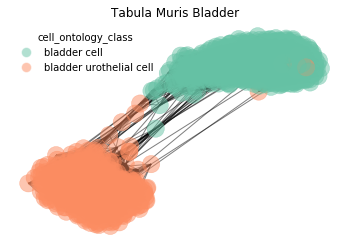

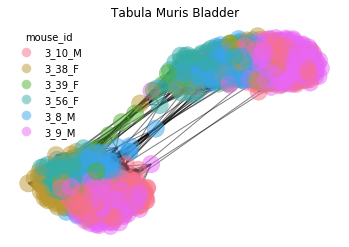

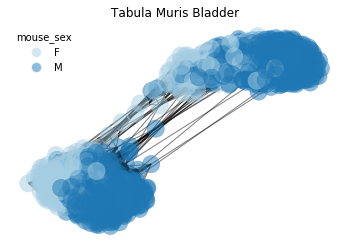

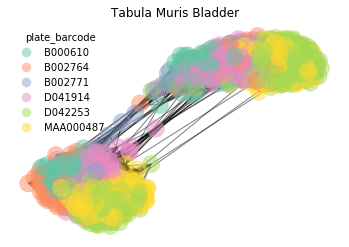

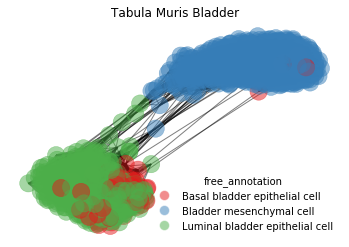

In [90]:
%%time

n_neighbors = 15
figure_folder = 's3://kmer-hashing/tabula-muris/n_hashes=500/bladder/'
figure_prefix = f'molecule={moltype}_ksize={ksize}_ignore-abundance={ignore_abundance}'
title = 'Tabula Muris Bladder'


key = f'k{ksize}_without_abundance_neighbors{n_neighbors}'

g, pos = khtools.knn.build_graph_and_plot(similarities, bladder_annotations, n_neighbors,
                                          color_cols, palettes, figure_folder, figure_prefix, title)

graphs[key] = g
positions[key] = pos

In [99]:
%%time

bladder_similarities_ignore_abundanceFalse = compare_all_pairs(bladder_signatures, ignore_abundance=False, n_jobs=32)
bladder_similarities_ignore_abundanceFalse = pd.DataFrame(bladder_similarities_ignore_abundanceFalse, index=cells, columns=cells)
bladder_similarities_ignore_abundanceFalse.head()

Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 1269 done in 0.00001 secondsetting similarities matrix for index 625 done in 0.00048 seconds


CPU times: user 7.06 s, sys: 2.8 s, total: 9.87 s
Wall time: 19.5 s


Time taken to compare all pairs parallely is 19.45078 seconds 


## Make Tidy dataframe to compare with and without abundance

In [ ]:
bladder_ignore_abundance_true_tidy = bladder_similarities_ignore_abundanceTrue_df.unstack().reset_index()
bladder_ignore_abundance_true_tidy = bladder_ignore_abundance_true_tidy.rename(columns={'level_0': 'cell1', 'level_1': 'cell2', 
                                                                                          0:'similarity_without_abundance'})
bladder_ignore_abundance_true_tidy.head()

In [100]:
bladder_ignore_abundance_false_tidy = bladder_similarities_ignore_abundanceFalse.unstack().reset_index()
bladder_ignore_abundance_false_tidy = bladder_ignore_abundance_false_tidy.rename(columns={'level_0': 'cell1', 'level_1': 'cell2', 
                                                                                          0:'similarity_with_abundance'})
bladder_ignore_abundance_false_tidy.head()

,cell1,cell2,similarity_with_abundance
0,A1-B000610-3_56_F-1-1,A1-B000610-3_56_F-1-1,1.000000
1,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,0.228460
2,A1-B000610-3_56_F-1-1,A1-B002771-3_39_F-1-1,0.245190
3,A1-B000610-3_56_F-1-1,A1-D041914-3_8_M-1-1,0.454728
4,A1-B000610-3_56_F-1-1,A1-D042253-3_9_M-1-1,0.231834


In [112]:
merge_cols = ['cell1', 'cell2']

bladder_similarities_tidy = bladder_ignore_abundance_true_tidy.merge(bladder_ignore_abundance_false_tidy, on=merge_cols)
bladder_similarities_tidy = bladder_similarities_tidy.join(annotations['cell_ontology_class'], on='cell1')
bladder_similarities_tidy = bladder_similarities_tidy.rename(columns={'cell_ontology_class': 'cell_ontology_class_cell1'})
bladder_similarities_tidy = bladder_similarities_tidy.join(annotations['cell_ontology_class'], on='cell2', rsuffix='_cell2')
print(bladder_similarities_tidy.shape)
bladder_similarities_tidy.head()


,cell1,cell2,similarity_without_abundance,similarity_with_abundance,cell_ontology_class_cell1,cell_ontology_class
0,A1-B000610-3_56_F-1-1,A1-B000610-3_56_F-1-1,1.000,1.000000,bladder cell,bladder cell
1,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,0.018,0.228460,bladder cell,bladder urothelial cell
2,A1-B000610-3_56_F-1-1,A1-B002771-3_39_F-1-1,0.072,0.245190,bladder cell,bladder cell
3,A1-B000610-3_56_F-1-1,A1-D041914-3_8_M-1-1,0.098,0.454728,bladder cell,bladder cell
4,A1-B000610-3_56_F-1-1,A1-D042253-3_9_M-1-1,0.090,0.231834,bladder cell,bladder cell


In [120]:
khtools.s3_utils.write_s3(bladder_similarities_tidy, 's3://kmer-hashing/tabula-muris/n_hashes=500/bladder/similarities_tidy.csv', index=False)

In [ ]:
bladder_similarities_tidy.to_csv()

In [113]:
bladder_similarities_tidy.sample(5)

,cell1,cell2,similarity_without_abundance,similarity_with_abundance,cell_ontology_class_cell1,cell_ontology_class
372172,D20-D042253-3_9_M-1-1,A4-B000610-3_56_F-1-1,0.068,0.066720,bladder urothelial cell,bladder cell
281060,C4-D042253-3_9_M-1-1,E6-B000610-3_56_F-1-1,0.090,0.048447,bladder cell,bladder urothelial cell
948775,J15-B002771-3_39_F-1-1,A9-B002764-3_38_F-1-1,0.086,0.118444,bladder cell,bladder urothelial cell
224325,C13-B002771-3_39_F-1-1,K1-MAA000487-3_10_M-1-1,0.096,0.118192,bladder urothelial cell,bladder cell
165840,B21-D041914-3_8_M-1-1,J14-B000610-3_56_F-1-1,0.070,0.079758,bladder urothelial cell,bladder cell


In [107]:
cell1 = 'A1-B000610-3_56_F-1-1'

sig1 = [x for x in bladder_signatures if x.name().startswith(cell1)][0]
sig1

SourmashSignature('A1-B000610-3_56_F-1-1_S28', 280b9bab)

In [115]:
cell2 = 'A1-B002764-3_38_F-1-1'

sig2 = [x for x in bladder_signatures if x.name().startswith(cell2)][0]
sig2

SourmashSignature('A1-B002764-3_38_F-1-1_S291', ef185816)

In [118]:
sig1.minhash?

Type:        MinHash
String form: <sourmash._minhash.MinHash object at 0x7f11195e8ad0>
Length:      500
File:        ~/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/sourmash-2.0.2.dev130+g0670d8a-py3.7-linux-x86_64.egg/sourmash/_minhash.cpython-37m-x86_64-linux-gnu.so
Docstring:   <no docstring>


CPU times: user 14 s, sys: 1.4 s, total: 15.4 s
Wall time: 16 s


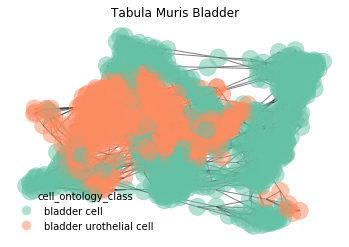

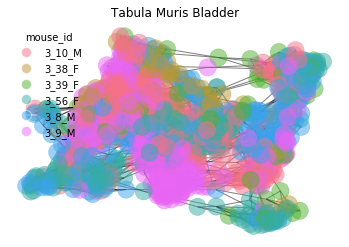

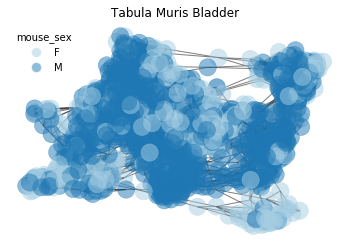

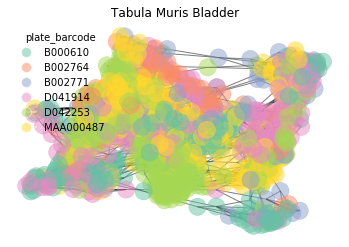

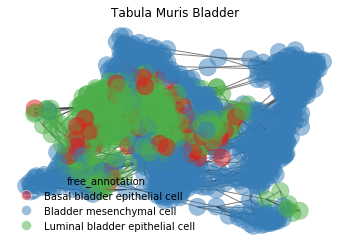

In [28]:
%%time


n_neighbors = 5
ignore_abundance = False
figure_folder = 's3://kmer-hashing/tabula-muris/n_hashes=500/bladder/'
figure_prefix = f'molecule={moltype}_ksize={ksize}_ignore-abundance={ignore_abundance}'
title = 'Tabula Muris Bladder'


key = f'k{ksize}_with_abundance_neighbors{n_neighbors}'


g, pos = khtools.knn.build_graph_and_plot(bladder_similarities_ignore_abundanceFalse, 
                                          bladder_annotations, n_neighbors,
                                          color_cols, palettes, figure_folder, figure_prefix, title)

# graphs[key] = g
# positions[key] = pos

CPU times: user 15.5 s, sys: 1.79 s, total: 17.3 s
Wall time: 17.3 s


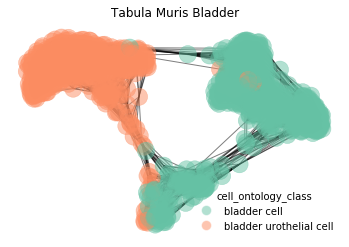

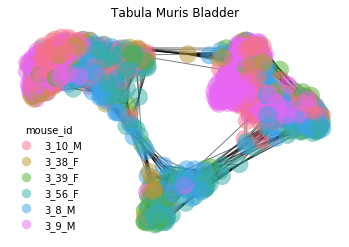

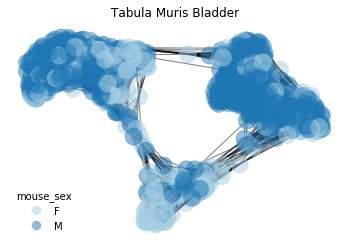

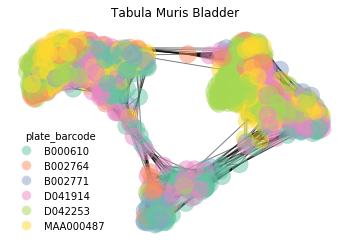

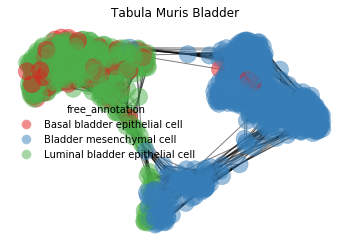

In [31]:
%%time

key = f'k{ksize}_with_abundance'

n_neighbors = 15
ignore_abundance = False
figure_folder = 's3://kmer-hashing/tabula-muris/n_hashes=500/bladder/'
figure_prefix = f'molecule={moltype}_ksize={ksize}_ignore-abundance={ignore_abundance}'
title = 'Tabula Muris Bladder'

g, pos = khtools.knn.build_graph_and_plot(bladder_similarities_ignore_abundanceFalse, 
                                          bladder_annotations, n_neighbors,
                                          color_cols, palettes, figure_folder, figure_prefix, title)

# graphs[key] = g
# positions[key] = pos

In [22]:
folder

'/home/olga/pureScratch/olgabot-maca/facs/sourmash/'

In [25]:
bladder_folder = f'/home/olga/pureScratch/olgabot-maca/facs/sourmash_tissues/bladder/'
! mkdir -p $bladder_folder

for sigfile in bladder_full_path:
    basename = os.path.basename(sigfile)
    new_location = f"{bladder_folder}/{basename}"
    ! ln -s $sigfile $new_location

## Try UMAP

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/olga/miniconda3/

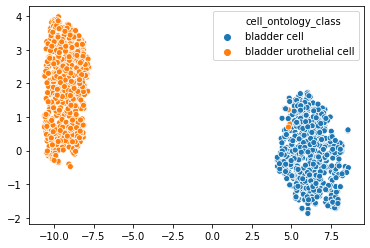

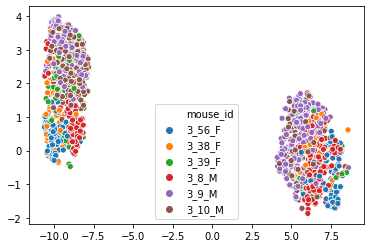

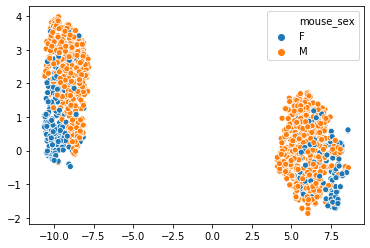

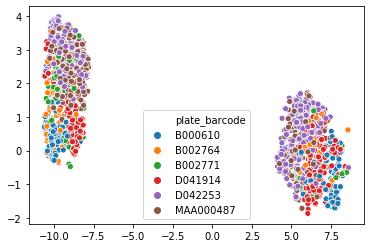

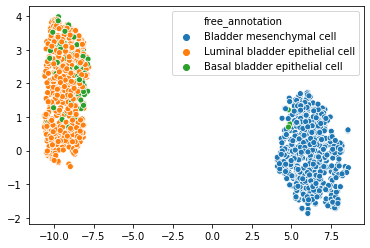

In [29]:
umapper = umap.UMAP(metric='precomputed', n_neighbors=5)
embedding = umapper.fit_transform(1-bladder_similarities_ignore_abundanceTrue)

x = embedding[:, 0]
y = embedding[:, 1]

for col in color_cols:
    hue = annotations.loc[cells, col]

    fig, ax = plt.subplots(figsize=(6, 4))

    sns.scatterplot(x, y, hue=hue)

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/olga/miniconda3/

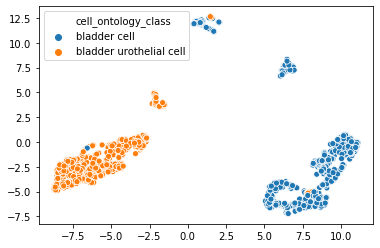

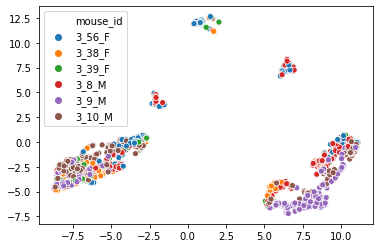

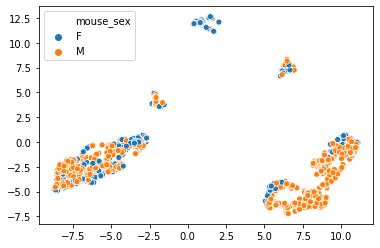

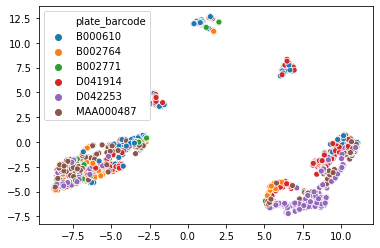

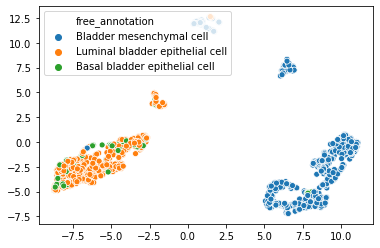

In [30]:
umapper = umap.UMAP(metric='precomputed', n_neighbors=5)
embedding = umapper.fit_transform(1-bladder_similarities_ignore_abundanceFalse)


x = embedding[:, 0]
y = embedding[:, 1]

for col in color_cols:
    hue = annotations.loc[cells, col]

    fig, ax = plt.subplots(figsize=(6, 4))

    sns.scatterplot(x, y, hue=hue)

### Make python-igraph for Leiden clustering

In [65]:
g = graphs['']

g_directed = g.to_directed()

In [69]:
for i, edge in zip(range(4), g_directed.edges()):
    print(edge)

('A1-B000610-3_56_F-1-1', 'A1-B000610-3_56_F-1-1')
('A1-B000610-3_56_F-1-1', 'F7-B002771-3_39_F-1-1')
('A1-B000610-3_56_F-1-1', 'D1-B000610-3_56_F-1-1')
('A1-B000610-3_56_F-1-1', 'O14-B000610-3_56_F-1-1')


In [71]:
g_directed.get_edge_data('A1-B000610-3_56_F-1-1', 'A1-B000610-3_56_F-1-1')

{}

In [75]:
igraph = ig.Graph(directed=True)
igraph.add_vertices([node for node in g_directed.nodes()])  # this adds n_leaves vertices
igraph.add_edges([(u, v) for (u, v) in g_directed.edges()])
igraph.es['weight'] = [bladder_similarities_ignore_abundanceTrue_df.loc[u, v] for (u, v) in g_directed.edges()]

In [82]:
partition_type = leidenalg.RBConfigurationVertexPartition
partition = leidenalg.find_partition(igraph, partition_type)
# store output into adata.obs
groups = np.array(partition.membership)
groups

array([6, 6, 5, ..., 1, 3, 7])

In [85]:
np.unique(groups)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [86]:
groups.shape

(1270,)

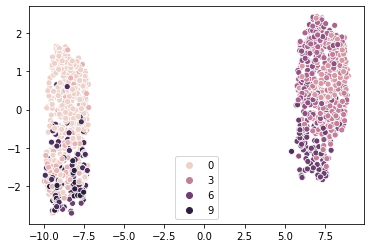

In [87]:
umapper = umap.UMAP(metric='precomputed', n_neighbors=5)
embedding = umapper.fit_transform(1-bladder_similarities_ignore_abundanceTrue_df)


x = embedding[:, 0]
y = embedding[:, 1]


sns.scatterplot(x, y, hue=groups)

## Import "traditional" rnaseq

In [33]:


h5ad = '/home/olga/ibm_lg/tabula-muris-senis/maca-facs-re-processed-annotated-fixed-tissues.h5ad'

tms = sc.read_h5ad(h5ad)
tms

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 81478 × 22901 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

In [34]:
tms

AnnData object with n_obs × n_vars = 81478 × 22901 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

In [45]:
tms_bladder_metadata = tms.obs.query('(tissue == "Bladder") & (age == "3m")')
tms_bladder_metadata = tms_bladder_metadata.replace('nan', np.nan)
print(tms_bladder_metadata.shape)
tms_bladder_metadata = tms_bladder_metadata.dropna(subset=['cell_ontology_class'])
print(tms_bladder_metadata.shape)
tms_bladder_metadata.head()

(1383, 16)
(1306, 16)


,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,plate,sex,subtissue,tissue,n_genes,n_counts,louvain,leiden
index,,,,,,,,,,,,,,,,
A1.B002771.3_39_F.1.1-1,3m,1,A1.B002771.3_39_F.1.1,bladder cell,CL:1001319,bladder mesenchymal cell (Car3+),facs,3_39_F,NaN,female,NaN,Bladder,3998,1044981.0,31,32
A1.D041914.3_8_M.1.1-1,3m,1,A1.D041914.3_8_M.1.1,bladder cell,CL:1001319,bladder mesenchymal cell (Car3+),facs,3_8_M,NaN,male,NaN,Bladder,3401,447232.0,31,32
A1.D042253.3_9_M.1.1-1,3m,1,A1.D042253.3_9_M.1.1,bladder cell,CL:1001319,bladder mesenchymal cell (Car3+),facs,3_9_M,NaN,male,NaN,Bladder,4439,330249.0,31,32
A1.MAA000487.3_10_M.1.1-1,3m,1,A1.MAA000487.3_10_M.1.1,bladder cell,CL:1001319,bladder mesenchymal cell (Scara5+),facs,3_10_M,NaN,male,NaN,Bladder,4471,748761.0,1,0
A10.B000610.3_56_F.1.1-1,3m,1,A10.B000610.3_56_F.1.1,bladder urothelial cell,CL:1001428,luminal bladder epithelial cell (umbrella cell),facs,3_56_F,NaN,female,NaN,Bladder,4182,1486054.0,21,20


In [46]:
bladder_adata = tms[tms_bladder_metadata.index, :]
bladder_adata

View of AnnData object with n_obs × n_vars = 1306 × 22901 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

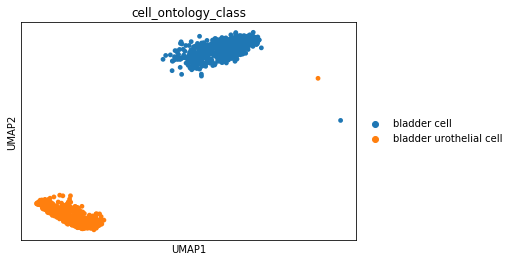

In [47]:
sc.pl.umap(bladder_adata, color='cell_ontology_class')

In [50]:
bladder_adata_binarized.X.shape

(1306, 22901)

In [52]:
type(bladder_adata_binarized.X)

anndata.core.views.SparseCSRView

In [54]:
X = bladder_adata_binarized.X.todense()
X[X > 1]

matrix([[2.0964525, 1.7989043, 1.4705493, ..., 1.1116811, 2.2734735,
         2.7093418]], dtype=float32)

In [55]:
bladder_adata_binarized = bladder_adata.copy()
X = bladder_adata_binarized.X
bladder_adata_binarized.X[X > 0] = 1
bladder_adata_binarized

AnnData object with n_obs × n_vars = 1306 × 22901 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'leiden', 'louvain', 'neighbors', 'pca', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

In [58]:
bladder_adata_binarized.X.todense()

matrix([[0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 0., 0.]], dtype=float32)

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 9 separate connected components using meta-embedding (experimental)
  n_components
/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


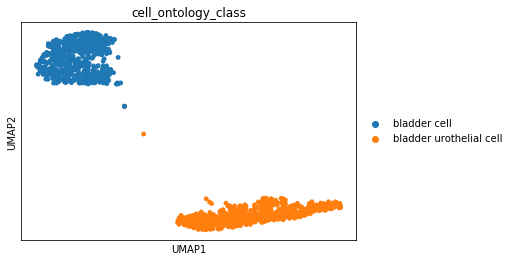

In [62]:
sc.tl.umap(bladder_adata_binarized)

sc.pl.umap(bladder_adata_binarized, color='cell_ontology_class', use_raw=True)